In [8]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
import time
import re

def sort_key(symbol):
    match = re.match(r"([a-zA-Z_]+)(.*)kg(\d+)", symbol.name)  # Updated regex
    if match:
        name, middle_part, number = match.groups()
        return (name, middle_part, int(number))  # Sort by name, middle, then number
    match = re.match(r"([a-zA-Z_]+)(\d+)", symbol.name) # Original regex for other cases
    if match:
        name, number = match.groups()
        return (name, int(number))
    return (symbol.name,)  # For symbols without numbers

def create_vars_dict(ordered_difference_vars):
    vars_dict = {}
    for var in ordered_difference_vars:
        match = re.match(r"([a-zA-Z_]+.*kg)", str(var))  # Match up to "kg"
        if match:
            name = match.group(1) # Extract the name including "kg"
            if name not in vars_dict:
                vars_dict[name] = []
            vars_dict[name].append(var)
        else:
            match = re.match(r"([a-zA-Z_]+)(\d+)", str(var))
            if match:
                name, index = match.groups()
                if name not in vars_dict:
                    vars_dict[name] = []
                vars_dict[name].append(var)
            else: # Single variables
                vars_dict[str(var)] = [var] # Use variable name as key directly
                # if 'other_vars' not in vars_dict:
                #     vars_dict['other_vars'] = []
                # vars_dict['other_vars'].append(var)
    return vars_dict


In [9]:
# import pickle file 
with open('../scenario-properties-test-opt-nospread.pkl', 'rb') as f:
# with open('../scenario-properties-test-opt-yesspread.pkl', 'rb') as f:
    baseline = pickle.load(f)

# Find the difference (symbols in equations but not in all_symbolic_vars) after 
# converting the list to a set for efficient difference calculation
difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
ordered_difference_vars = sorted(list(difference_vars), key=sort_key)

vars_dict = create_vars_dict(ordered_difference_vars)
# for name, var_list in vars_dict.items():
#     print(f"{name}: {var_list}")

equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

#==========================================================================
# Define symbolic variables based on loaded scenario
#==========================================================================
lam_s = vars_dict['lambda_Su']
var_s = baseline.all_symbolic_vars
var_c = var_s + lam_s

active_species_indices = int(len(lam_s)/N_shell)
active_species_per_shells = len(lam_s)

print("-----------------------------------------")
print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
print(f"Number of shells: {baseline.n_shells}")
print(f"Number of active species: {active_species_indices}")
print(f"Number of active species per shell: {active_species_per_shells}")
print("-----------------------------------------")

#==========================================================================
# Define propagation function
#==========================================================================

func = sp.lambdify((var_s, lam_s), equations_flattened, 'numpy')

def ode_func(t, x, func, mdd):
    return np.array(func(x, mdd)).flatten()


-----------------------------------------
3 species: Su, N, N_200.0kg
Number of shells: 24
Number of active species: 1
Number of active species per shell: 24
-----------------------------------------


In [10]:
## Initial condition
x0 = [0,
           7,
          38,
          44,
         173,
         456,
        2977,
         379,
         157,
          79,
          59,
         144,
          43,
          17,
          15,
          10,
           1,
          43,
           3,
         101,
         277,
           0,
           2,
           0,
           23,
          15,
          32,
          91,
         186,
         227,
         194,
         309,
         340,
         519,
         830,
        1223,
        1381,
        1160,
         696,
         487,
         353,
         256,
         207,
         145,
         104,
         244,
          86,
           0,
           8,
           3,
          10,
          31,
         114,
          91,
         117,
          98,
         129,
         120,
         150,
         215,
         144,
          80,
         116,
         288,
          56,
          73,
          35,
          39,
          11,
           9,
          18,
           0]
x0 = np.array(x0)
x0 = x0.astype(int)
# Create pandas DataFrame (equivalent to MATLAB's table)
df = pd.DataFrame(x0.reshape((baseline.species_length,N_shell)).T, columns=baseline.species_names)
# print(df.to_string(index=False)) # Print DataFrame without index

# Print table with shell numbers (optional)
df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
                                columns=['Shell'] + baseline.species_names)
print(df_with_shell.to_string(index=False)) # Print DataFrame without index

x0_lam = np.ones(N_shell) * 50

 Shell   Su    N  N_200.0kg
     1    0   23          8
     2    7   15          3
     3   38   32         10
     4   44   91         31
     5  173  186        114
     6  456  227         91
     7 2977  194        117
     8  379  309         98
     9  157  340        129
    10   79  519        120
    11   59  830        150
    12  144 1223        215
    13   43 1381        144
    14   17 1160         80
    15   15  696        116
    16   10  487        288
    17    1  353         56
    18   43  256         73
    19    3  207         35
    20  101  145         39
    21  277  104         11
    22    0  244          9
    23    2   86         18
    24    0    0          0


In [11]:
#==========================================================================
# Propagation without control
#==========================================================================

# Propagation time
tf_ss = 100.0
dur = tf_ss
Ts = 1.0
tspan = np.arange(0, dur+Ts, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

x00 = x0
x_prop = np.zeros((len(tspan), baseline.species_length*N_shell))
x_prop[0, :] = x00

start_time = time.time()
for i1 in range(len(tspan) - 1):
    md = x0_lam
    sol = solve_ivp(ode_func, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func,md),
                    rtol=rtol, atol=atol)
    x_prop[i1+1, :] = sol.y[:, -1]
    x00 = sol.y[:, -1]
    
propagation_time = time.time() - start_time
print(f"Propagation time (no control): {propagation_time:.4f} seconds")    
t_prop = tspan

Propagation time (no control): 0.4814 seconds


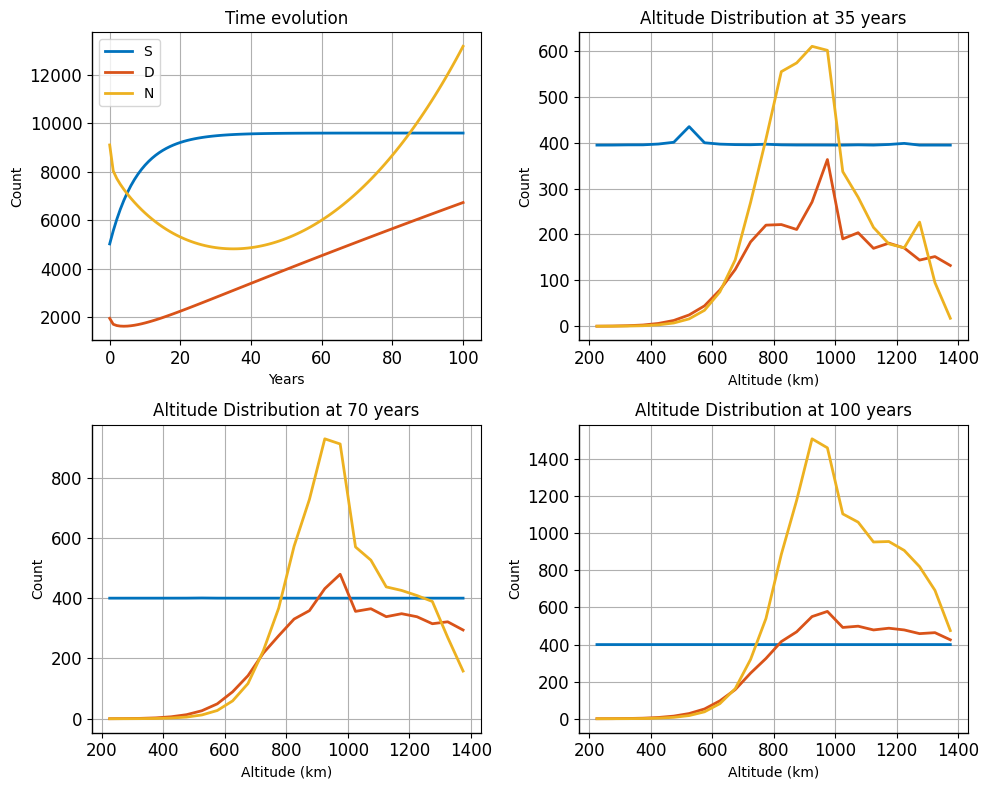

In [12]:
# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 12

# Create Subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), facecolor='w') # 2 rows, 2 columns

# Plot 1
S_prop = x_prop[:,0:N_shell]
N_prop = x_prop[:,N_shell:2*N_shell]
D_prop = x_prop[:,2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
N_tot_sum = np.sum(N_tot,1)
S_sum = np.sum(S_prop,1)
D_sum = np.sum(D_prop,1)
N_sum = np.sum(N_prop,1)
axes[0, 0].grid(True)
axes[0, 0].plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth)
axes[0, 0].plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth)
axes[0, 0].plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth)
axes[0, 0].set_title("Time evolution")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend(["S", "D", "N"], loc="best")
axes[0, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[0, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[0, 0].spines['left'].set_linewidth(sel_LineWidthAxis)

# Plot 2
S_prop = x_prop[35,0:N_shell]
N_prop = x_prop[35,N_shell:2*N_shell]
D_prop = x_prop[35,2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
axes[0, 1].grid(True)
axes[0, 1].plot(R02[1:] - 25, S_prop, '-', color=colors[1], linewidth=sel_LineWidth)
axes[0, 1].plot(R02[1:] - 25, D_prop, '-', color=colors[2], linewidth=sel_LineWidth)
axes[0, 1].plot(R02[1:] - 25, N_prop, '-', color=colors[3], linewidth=sel_LineWidth)
axes[0, 1].set_title(f"Altitude Distribution at {t_prop[35]:.0f} years")
axes[0, 1].set_xlabel("Altitude (km)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[0, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[0, 1].spines['left'].set_linewidth(sel_LineWidthAxis)

# Plot 3
S_prop = x_prop[70,0:N_shell]
N_prop = x_prop[70,N_shell:2*N_shell]
D_prop = x_prop[70,2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
axes[1, 0].grid(True)
axes[1, 0].plot(R02[1:] - 25, S_prop, '-', color=colors[1], linewidth=sel_LineWidth)
axes[1, 0].plot(R02[1:] - 25, D_prop, '-', color=colors[2], linewidth=sel_LineWidth)
axes[1, 0].plot(R02[1:] - 25, N_prop, '-', color=colors[3], linewidth=sel_LineWidth)
axes[1, 0].set_title(f"Altitude Distribution at {t_prop[70]:.0f} years")
axes[1, 0].set_xlabel("Altitude (km)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[1, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[1, 0].spines['left'].set_linewidth(sel_LineWidthAxis)

# Plot 3
S_prop = x_prop[-1,0:N_shell]
N_prop = x_prop[-1,N_shell:2*N_shell]
D_prop = x_prop[-1,2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
axes[1, 1].grid(True)
axes[1, 1].plot(R02[1:] - 25, S_prop, '-', color=colors[1], linewidth=sel_LineWidth)
axes[1, 1].plot(R02[1:] - 25, D_prop, '-', color=colors[2], linewidth=sel_LineWidth)
axes[1, 1].plot(R02[1:] - 25, N_prop, '-', color=colors[3], linewidth=sel_LineWidth)
axes[1, 1].set_title(f"Altitude Distribution at {t_prop[-1]:.0f} years")
axes[1, 1].set_xlabel("Altitude (km)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[1, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[1, 1].spines['left'].set_linewidth(sel_LineWidthAxis)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

